# Probabilistic Signal Estimator

The question we want to answer is the following. How long does it take to reach +2% gain from now?

In [1]:
from hypecommons import *
from hypecommons import plot as hyplot

from datetime import datetime, timedelta

In [3]:
SYMBOL = 'DOGEBUSD'
FREQ = 1
START = '20210101000000'
TARGET = 1.02
DAYS = 150

In [4]:
df = download_history_fast(SYMBOL, START, freq=FREQ, days=DAYS)

In [5]:
print(str(df.iloc[0]) + '\n\n' + str(df.iloc[-1]))

open      0.004699
high      0.004699
low       0.004699
close     0.004699
volume    0.000000
trades    0.000000
Name: 2021-01-01 00:00:00, dtype: float64

open           0.30188
high           0.30188
low            0.30052
close          0.30067
volume    111523.00000
trades        85.00000
Name: 2021-05-31 01:00:00, dtype: float64


As the goal is to achieve a given value, the `high` price value is used. Binance allows users to create future orders with a limit, therefore this behaviour can be reproduced also in a real-time setting.

In [6]:
def minutes_to_target(df, start, target):
    t0 = df.index[start]
    close0 = df['close'].iloc[start]
    try:
        t1 = df[(df.index > t0) & (df['high'] >= target * close0)].index[0]
    except IndexError:
        return None, None # it never achieves the target
    return t1, round((t1 - t0).total_seconds() / 60.0)

In [7]:
x0 = minutes_to_target(df, 0, target=TARGET)
print(x0)
df.iloc[int(x0[1]/FREQ)]['high'] / df.iloc[0]['close']

(Timestamp('2021-01-01 03:19:00'), 199)


1.0217067461161948

In [8]:
mins2tgt = []

rng = range(len(df))[::100]

for i in tqdm(rng):
    t, y = minutes_to_target(df, i, target=TARGET)
    if y:
        mins2tgt.append(y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2154/2154 [00:07<00:00, 300.23it/s]


In [9]:
df_m = pd.DataFrame(mins2tgt)
pos, total = len(df_m[df_m[0] <= 600]), len(df_m)
print(f"In {pos} cases out of {total} (~{pos/total*100:.0f}%), 2% gain is reached after less than 10 hours.")

In 1412 cases out of 2091 (~68%), 2% gain is reached after less than 10 hours.


First 10 bins: [1329.  209.  109.   73.   49.   35.   27.   37.   25.   14.]


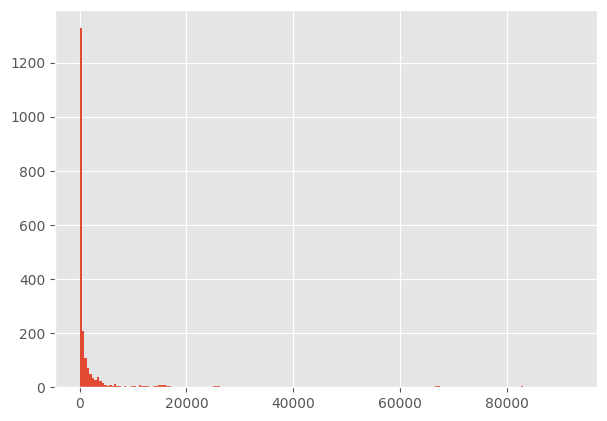

In [10]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (7,5), 'figure.dpi': 100})

n_bins = 200
hist_x, hist_y, hist_z = plt.hist(mins2tgt, bins=n_bins)

print(f"First 10 bins: {hist_x[:10]}")

In [11]:
print(f"Each bin represents around 60000/{n_bins} = {60000/n_bins} minutes = {60000/n_bins/60} hours of time,\n"
      f"which means {sum(hist_x[:1])/len(mins2tgt)*100:.1f}% of the time we reach +2% gain within {60000/n_bins/60} hours,\n"
      f"{sum(hist_x[:2])/len(mins2tgt)*100:.1f}% of the time within {2*60000/n_bins/60} hours, and so on.")


Each bin represents around 60000/200 = 300.0 minutes = 5.0 hours of time,
which means 63.6% of the time we reach +2% gain within 5.0 hours,
73.6% of the time within 10.0 hours, and so on.


In [131]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def normalise(df_orig):
    df = df_orig.copy()
    
    fields = list(df)
    
    for field in fields:
        if field in ['volume', 'trades']:
            for ma in [1, 3, 9]:
                df[f"{field}_pm_ma{ma}"] = df[field].rolling(window=ma).mean() / FREQ
        else:
            if field != 'close':
                df[f"{field}_norm"] = df[field] / df['close']

#         if field != 'close':
#             df.drop(field, axis=1, inplace=True)
    
    for x in [50, 200]:
        df[f"close_ma{x}_norm"] = df['close'].rolling(window=x).mean() / df['close']
    
    for x in [12, 26]:
        df[f"close_ema{x}_norm"] = ema(df['close'], x) / df['close']
    
#     df.drop('close', axis=1, inplace=True)
    return df

In [12]:
df_n = normalise(df)
df_n

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm
2021-01-01 00:00:00,1.000000,1.000000,1.000000,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.000000,1.000000
2021-01-01 00:01:00,1.000000,1.000000,1.000000,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.000000,1.000000
2021-01-01 00:02:00,1.000000,1.000000,1.000000,277539.0,92513.000000,NaN,5.0,1.666667,NaN,NaN,NaN,1.002891,1.003164
2021-01-01 00:03:00,1.000000,1.000000,1.000000,258126.0,178555.000000,NaN,4.0,3.000000,NaN,NaN,NaN,1.002446,1.002929
2021-01-01 00:04:00,1.000000,1.000000,1.000000,74019.0,203228.000000,NaN,3.0,4.000000,NaN,NaN,NaN,1.002070,1.002712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998443,1.000000,0.998443,8616.8,11178.300000,133505.155556,12.0,11.000000,53.111111,1.004036,1.006595,1.000454,1.002002
2021-05-31 00:57:00,0.997291,1.000000,0.997291,33923.9,15435.400000,129629.355556,40.0,20.000000,51.111111,1.001503,1.004024,0.998286,0.999554
2021-05-31 00:58:00,1.000132,1.000265,0.999041,42614.4,28385.033333,130973.711111,32.0,28.000000,51.444444,1.002597,1.005113,0.999528,1.000659
2021-05-31 00:59:00,1.000563,1.000629,0.999669,11526.4,29354.900000,94443.122222,18.0,30.000000,46.555556,1.003136,1.005640,1.000104,1.001162


In [13]:
from joblib import Parallel, delayed  

def compute_mins(i):
    t, y = minutes_to_target(df, i, target=TARGET)
    if y:
        return y
    else:
        return 120000

mins2tgt = Parallel(n_jobs=16)(delayed(compute_mins)(i) for i in tqdm(range(len(df))))

df_n['mins2tgt'] = mins2tgt

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215398/215398 [10:20<00:00, 346.95it/s]


In [14]:
df.to_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-raw-{TARGET}.csv")
df_n.to_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-norm-{TARGET}.csv")

In [15]:
df_n.dropna(inplace=True)
df_n

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-01-01 03:19:00,0.999792,1.000000,0.999792,123670.0,44275.333333,15127.222222,5.0,2.666667,1.000000,0.990977,0.982687,0.995544,0.993679,21
2021-01-01 03:20:00,1.000000,1.000000,1.000000,418407.0,182640.000000,61248.111111,4.0,3.666667,1.333333,0.991210,0.982793,0.996230,0.994147,20
2021-01-01 03:21:00,1.000000,1.000000,1.000000,0.0,180692.333333,61248.111111,0.0,3.000000,1.333333,0.991443,0.982899,0.996810,0.994580,19
2021-01-01 03:22:00,1.000000,1.000000,1.000000,4800.0,141069.000000,61781.444444,1.0,1.666667,1.444444,0.993908,0.985268,0.999238,0.997097,18
2021-01-01 03:23:00,1.000000,1.000000,1.000000,0.0,1600.000000,61781.444444,0.0,0.333333,1.444444,0.994096,0.985380,0.999355,0.997312,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998443,1.000000,0.998443,8616.8,11178.300000,133505.155556,12.0,11.000000,53.111111,1.004036,1.006595,1.000454,1.002002,120000
2021-05-31 00:57:00,0.997291,1.000000,0.997291,33923.9,15435.400000,129629.355556,40.0,20.000000,51.111111,1.001503,1.004024,0.998286,0.999554,120000
2021-05-31 00:58:00,1.000132,1.000265,0.999041,42614.4,28385.033333,130973.711111,32.0,28.000000,51.444444,1.002597,1.005113,0.999528,1.000659,120000
2021-05-31 00:59:00,1.000563,1.000629,0.999669,11526.4,29354.900000,94443.122222,18.0,30.000000,46.555556,1.003136,1.005640,1.000104,1.001162,120000


In [17]:
df_n[df_n['mins2tgt'] == 120000]

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-05-07 23:40:00,0.988413,1.004332,0.986568,4655418.8,4.056543e+06,2.669492e+06,4261.0,3761.333333,2624.333333,0.948828,0.901163,0.978100,0.966504,120000
2021-05-07 23:45:00,0.988978,1.001261,0.987704,2262169.6,2.147714e+06,3.417316e+06,2409.0,2300.666667,3509.666667,0.957807,0.906443,0.987223,0.976528,120000
2021-05-08 05:14:00,0.992962,1.000536,0.992508,1370552.0,9.201760e+05,8.072081e+05,1716.0,1352.333333,1110.666667,0.975786,0.956975,0.989761,0.984242,120000
2021-05-08 05:15:00,0.996971,1.000480,0.995011,2477284.8,1.499502e+06,9.875416e+05,2472.0,1779.000000,1228.444444,0.973629,0.954497,0.988811,0.982662,120000
2021-05-08 05:50:00,0.997026,1.001625,0.995153,1907478.4,1.114560e+06,7.738943e+05,1677.0,1187.000000,908.666667,0.989461,0.967900,0.993428,0.990482,120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998443,1.000000,0.998443,8616.8,1.117830e+04,1.335052e+05,12.0,11.000000,53.111111,1.004036,1.006595,1.000454,1.002002,120000
2021-05-31 00:57:00,0.997291,1.000000,0.997291,33923.9,1.543540e+04,1.296294e+05,40.0,20.000000,51.111111,1.001503,1.004024,0.998286,0.999554,120000
2021-05-31 00:58:00,1.000132,1.000265,0.999041,42614.4,2.838503e+04,1.309737e+05,32.0,28.000000,51.444444,1.002597,1.005113,0.999528,1.000659,120000
2021-05-31 00:59:00,1.000563,1.000629,0.999669,11526.4,2.935490e+04,9.444312e+04,18.0,30.000000,46.555556,1.003136,1.005640,1.000104,1.001162,120000


In [18]:
signal_cat = ['VERY HIGH', 'HIGH', 'NORMAL', 'LOW', 'VERY LOW']
signal_thr = [0.2, 0.4, 0.6, 0.8, 1.0]

def find_quantiles(df_q):
    quantiles = []
    for c, q in zip(signal_cat, signal_thr):
        quantiles.append({'cat': c, 'quantile': q, 'value': df_q['mins2tgt'].quantile(q)})
    return quantiles

quantiles = find_quantiles(df_n)
quantiles

[{'cat': 'VERY HIGH', 'quantile': 0.2, 'value': 32.0},
 {'cat': 'HIGH', 'quantile': 0.4, 'value': 128.0},
 {'cat': 'NORMAL', 'quantile': 0.6, 'value': 416.0},
 {'cat': 'LOW', 'quantile': 0.8, 'value': 1833.0},
 {'cat': 'VERY LOW', 'quantile': 1.0, 'value': 120000.0}]

In [19]:
print(f"Everything higher than {quantiles[-2]['value']} will be treated as VERY LOW, therefore we can remove\n"
      f"the last rows within such interval.")

Everything higher than 1833.0 will be treated as VERY LOW, therefore we can remove
the last rows within such interval.


In [20]:
df_n[df_n.index >= df_n.index[-1]]

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-05-31 01:00:00,1.004024,1.004024,0.999501,111523.0,55221.266667,79569.955556,85.0,45.0,31.0,1.00774,1.010356,1.004141,1.005516,120000


In [21]:
remove_after_this = df_n.index[-1] - timedelta(minutes=quantiles[-2]['value'])
df_ml = df_n[df_n.index < remove_after_this].copy()
df_ml

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-01-01 03:19:00,0.999792,1.000000,0.999792,123670.0,44275.333333,15127.222222,5.0,2.666667,1.000000,0.990977,0.982687,0.995544,0.993679,21
2021-01-01 03:20:00,1.000000,1.000000,1.000000,418407.0,182640.000000,61248.111111,4.0,3.666667,1.333333,0.991210,0.982793,0.996230,0.994147,20
2021-01-01 03:21:00,1.000000,1.000000,1.000000,0.0,180692.333333,61248.111111,0.0,3.000000,1.333333,0.991443,0.982899,0.996810,0.994580,19
2021-01-01 03:22:00,1.000000,1.000000,1.000000,4800.0,141069.000000,61781.444444,1.0,1.666667,1.444444,0.993908,0.985268,0.999238,0.997097,18
2021-01-01 03:23:00,1.000000,1.000000,1.000000,0.0,1600.000000,61781.444444,0.0,0.333333,1.444444,0.994096,0.985380,0.999355,0.997312,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29 18:22:00,0.998807,1.000954,0.997989,22880.3,76176.466667,104958.866667,46.0,71.666667,103.111111,1.008200,0.993174,1.002103,1.004899,266
2021-05-29 18:23:00,1.001057,1.001569,0.999011,91818.9,63737.000000,92658.355556,51.0,57.000000,94.888889,1.008760,0.993615,1.002243,1.005044,265
2021-05-29 18:24:00,0.998398,1.001398,0.998023,49333.8,54677.666667,91596.633333,50.0,49.000000,86.888889,1.008141,0.992863,1.001348,1.004067,264
2021-05-29 18:25:00,0.996533,1.001835,0.996431,136435.0,92529.233333,97668.177778,114.0,71.666667,92.777778,1.005178,0.989911,0.998693,1.001080,357


In [22]:
df_ml.to_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-ml-{TARGET}.csv")

## Train model

A few data visualisations...

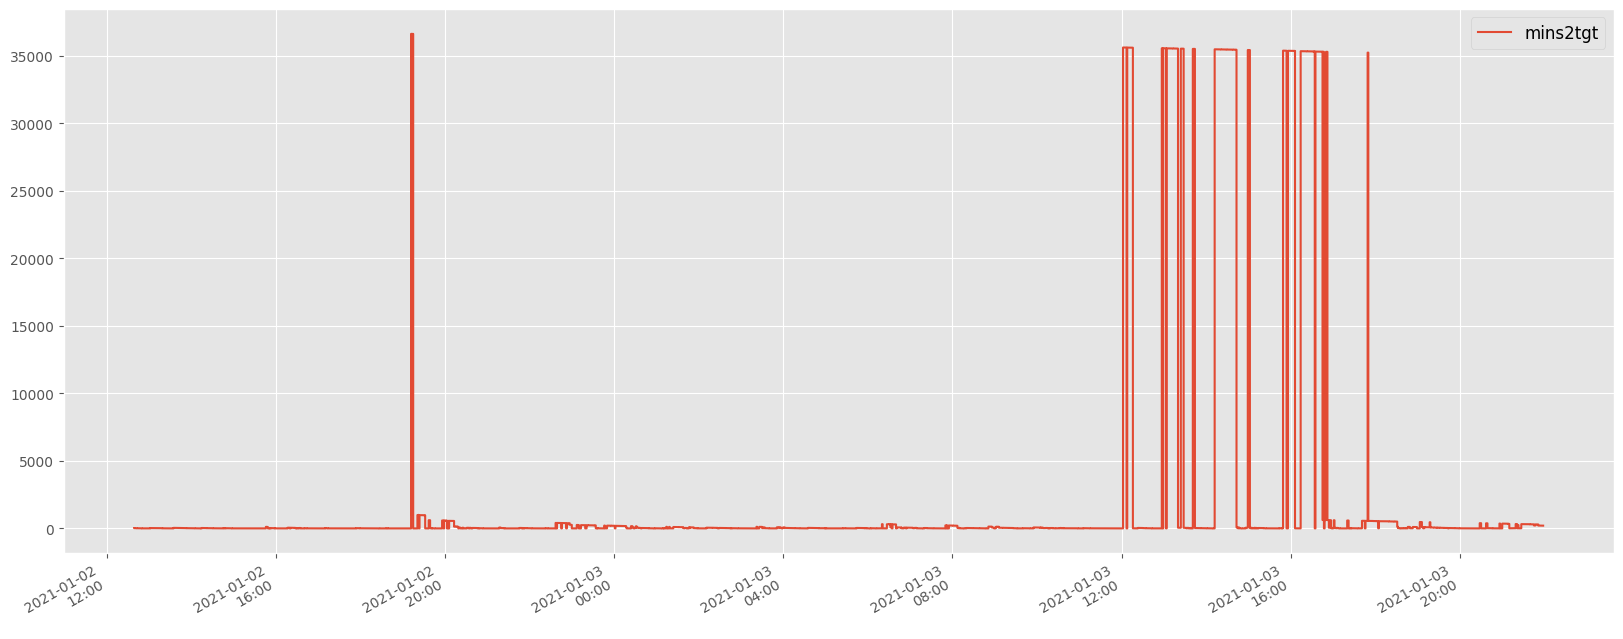

In [23]:
plot(plt.plot, df_n.iloc[2000:4000], ['mins2tgt'])

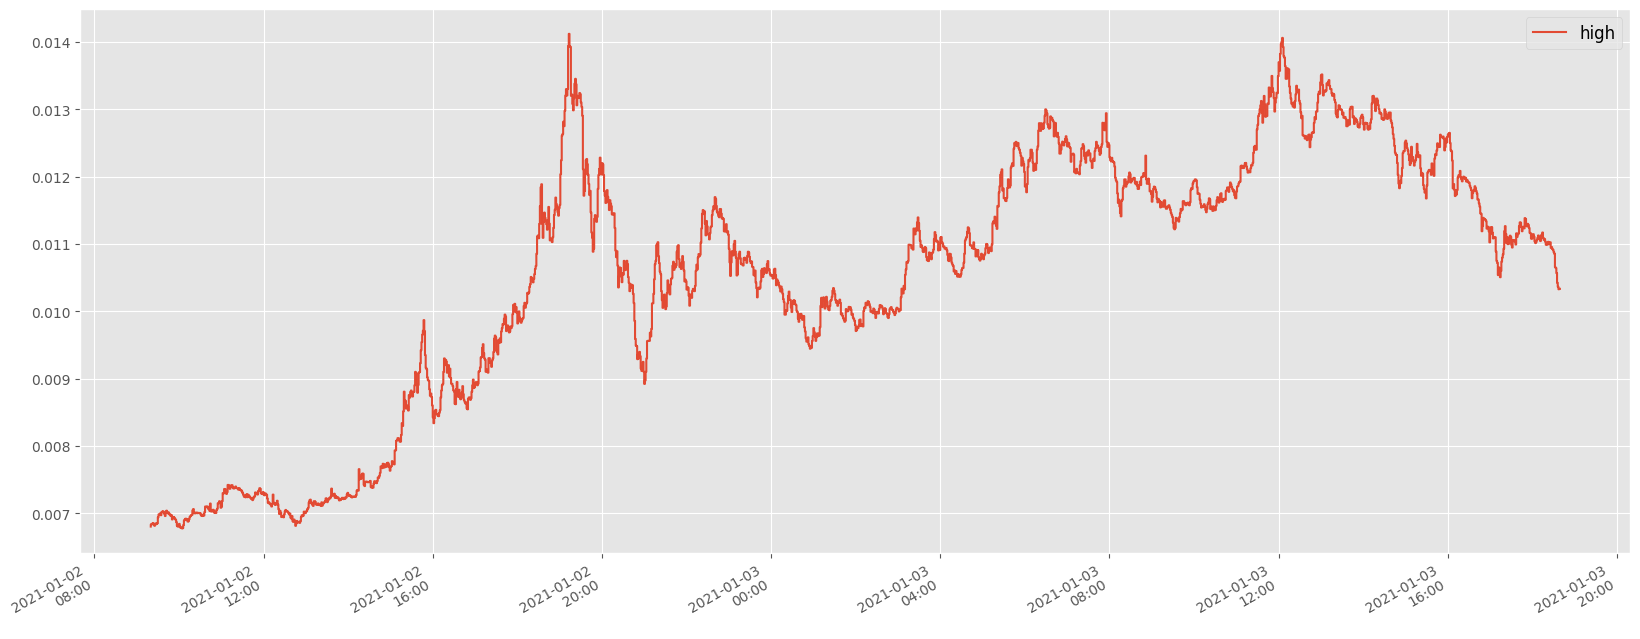

In [24]:
plot(plt.plot, df.dropna().iloc[2000:4000], ['high'])

In [25]:
# p = 3009
# print(df.dropna().iloc[p])

# print(f"\ntarget: {df.dropna().iloc[p]['close'] * 1.02}")

# df[df.index == df.dropna().index[p] + timedelta(minutes=df.dropna().iloc[p]['mins2tgt'])]

In [26]:
df['mins2tgt'] = df_n['mins2tgt']

In [27]:
df_n

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-01-01 03:19:00,0.999792,1.000000,0.999792,123670.0,44275.333333,15127.222222,5.0,2.666667,1.000000,0.990977,0.982687,0.995544,0.993679,21
2021-01-01 03:20:00,1.000000,1.000000,1.000000,418407.0,182640.000000,61248.111111,4.0,3.666667,1.333333,0.991210,0.982793,0.996230,0.994147,20
2021-01-01 03:21:00,1.000000,1.000000,1.000000,0.0,180692.333333,61248.111111,0.0,3.000000,1.333333,0.991443,0.982899,0.996810,0.994580,19
2021-01-01 03:22:00,1.000000,1.000000,1.000000,4800.0,141069.000000,61781.444444,1.0,1.666667,1.444444,0.993908,0.985268,0.999238,0.997097,18
2021-01-01 03:23:00,1.000000,1.000000,1.000000,0.0,1600.000000,61781.444444,0.0,0.333333,1.444444,0.994096,0.985380,0.999355,0.997312,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998443,1.000000,0.998443,8616.8,11178.300000,133505.155556,12.0,11.000000,53.111111,1.004036,1.006595,1.000454,1.002002,120000
2021-05-31 00:57:00,0.997291,1.000000,0.997291,33923.9,15435.400000,129629.355556,40.0,20.000000,51.111111,1.001503,1.004024,0.998286,0.999554,120000
2021-05-31 00:58:00,1.000132,1.000265,0.999041,42614.4,28385.033333,130973.711111,32.0,28.000000,51.444444,1.002597,1.005113,0.999528,1.000659,120000
2021-05-31 00:59:00,1.000563,1.000629,0.999669,11526.4,29354.900000,94443.122222,18.0,30.000000,46.555556,1.003136,1.005640,1.000104,1.001162,120000


## Load from file

In [25]:
from hypecommons import *
from hypecommons import plot as hyplot

from datetime import datetime, timedelta

In [26]:
import pandas as pd

SYMBOL = 'BNBBUSD'
FREQ = 1
START = '20210101000000'
TARGET = 1.02
DAYS = 150

df = download_history_fast(SYMBOL, START, freq=FREQ, days=DAYS)

df_ml = pd.read_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-ml-{TARGET}.csv").set_index('Unnamed: 0')
df_ml = df_ml.set_index(pd.to_datetime(df_ml.index))
df_ml

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
Unnamed: 0,,,,,,,,,,,,,,
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277,419
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653,419
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313,418
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932,417
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29 18:03:00,1.000739,1.001863,0.998715,529.6373,566.792833,1124.440022,342.0,318.000000,463.888889,0.999423,1.006492,1.003394,1.002553,733
2021-05-29 18:04:00,1.000354,1.002766,0.998842,819.3472,590.358600,1007.748111,374.0,323.666667,391.777778,1.000623,1.007335,1.003663,1.003229,732
2021-05-29 18:05:00,1.002256,1.002482,0.999323,385.6909,578.225133,909.833222,323.0,346.333333,366.666667,1.003070,1.009476,1.005016,1.005086,731


### TODO this is where it should be

In [3]:
signal_cat = ['VERY HIGH', 'HIGH', 'NORMAL', 'LOW', 'VERY LOW']
signal_thr = [0.2, 0.4, 0.6, 0.8, 1.0]

def find_quantiles(df_q):
    quantiles = []
    for c, q in zip(signal_cat, signal_thr):
        quantiles.append({'cat': c, 'quantile': q, 'value': df_q['mins2tgt'].quantile(q)})
    return quantiles

quantiles = find_quantiles(df_ml)
quantiles

[{'cat': 'VERY HIGH', 'quantile': 0.2, 'value': 76.0},
 {'cat': 'HIGH', 'quantile': 0.4, 'value': 212.0},
 {'cat': 'NORMAL', 'quantile': 0.6, 'value': 534.0},
 {'cat': 'LOW', 'quantile': 0.8, 'value': 1836.0},
 {'cat': 'VERY LOW', 'quantile': 1.0, 'value': 120000.0}]

In [34]:
df_ml['cat'] = None

def to_cat(x):
    for q in reversed(quantiles):
        if x <= q['value']:
            res = q['cat']
    return res

df_ml['cat'] = df_ml['mins2tgt'].map(to_cat)
df_ml

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt,cat
Unnamed: 0,,,,,,,,,,,,,,,
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277,419,NORMAL
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653,419,NORMAL
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313,418,NORMAL
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932,417,NORMAL
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767,415,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29 18:03:00,1.000739,1.001863,0.998715,529.6373,566.792833,1124.440022,342.0,318.000000,463.888889,0.999423,1.006492,1.003394,1.002553,733,LOW
2021-05-29 18:04:00,1.000354,1.002766,0.998842,819.3472,590.358600,1007.748111,374.0,323.666667,391.777778,1.000623,1.007335,1.003663,1.003229,732,LOW
2021-05-29 18:05:00,1.002256,1.002482,0.999323,385.6909,578.225133,909.833222,323.0,346.333333,366.666667,1.003070,1.009476,1.005016,1.005086,731,LOW


In [5]:
str(list(df_ml.columns))

"['open_norm', 'high_norm', 'low_norm', 'volume_pm_ma1', 'volume_pm_ma3', 'volume_pm_ma9', 'trades_pm_ma1', 'trades_pm_ma3', 'trades_pm_ma9', 'close_ma50_norm', 'close_ma200_norm', 'close_ema12_norm', 'close_ema26_norm', 'mins2tgt', 'cat']"

In [6]:
feat_cols = ['open_norm', 'high_norm', 'low_norm', 'volume_pm_ma1', 'volume_pm_ma3', 
             'volume_pm_ma9', 'trades_pm_ma1', 'trades_pm_ma3', 'trades_pm_ma9', 
             'close_ma50_norm', 'close_ma200_norm', 'close_ema12_norm', 'close_ema26_norm']
df_ml_feats = df_ml[feat_cols]

## Dimensionality reduction and visualisation

In [7]:
# # apply dimensionality reduction

# # from sklearn.decomposition import PCA
# # pca = PCA(n_components=2)
# # dimred_result = pca.fit_transform(df_ml_feats)

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
# dimred_result = tsne.fit_transform(df_ml_feats)

# import numpy as np
# import math
# import matplotlib.pyplot as plt

# plt.figure(figsize=(16,10))

# to_colour = {}
# for q in quantiles:
#     to_colour[q['cat']] = len(to_colour)

# colours = [to_colour[x] for x in list(df_ml['cat'])]

# plt.scatter(dimred_result[:,0], dimred_result[:,1], c=colours)
# plt.legend(loc="upper left")

In [8]:
len(df_ml_feats)

213346

## Multiclass model training

In [35]:
# import numpy as np
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC

# TRAINING_SIZE = 100000

# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(df_ml_feats[:TRAINING_SIZE], df_ml['cat'][:TRAINING_SIZE])

In [39]:
# from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# def evaluate():
#     # evaluate on last N examples
#     N = 20000
#     labels = list(reversed(signal_cat))
#     test = df_ml_feats.tail(N)
#     actual = df_ml['cat'].tail(N)
#     pred = clf.predict(test)
#     cm = confusion_matrix(actual, pred, labels=labels)
#     prf = precision_recall_fscore_support(actual, pred, labels=labels)
#     print(f"{cm}\n")
#     T = 10
#     print("          \t" + "\t".join(labels).expandtabs(T))
#     print("Precision:\t" + "\t".join([f"{x:.3f}" for x in prf[0]]).expandtabs(T))
#     print("Recall:   \t" + "\t".join([f"{x:.3f}" for x in prf[1]]).expandtabs(T))
#     print("F-Score:  \t" + "\t".join([f"{x:.3f}" for x in prf[2]]).expandtabs(T))

# evaluate()

In [40]:
# df_ml_feats

In [41]:
# df_ml

In [42]:
# df_plot

## Signal detection

Each dot is a moment between Jan 1st and June 1st this year. The blue dots are moments with a high buy signal where the price went +2% in less than 30 hours (`VERY HIGH`, `HIGH`, `NORMAL`, and `LOW` categories). My aim is to detect them automatically.

In [43]:
# filter out y=120k (which means 'never reaches +2%') and y>40k (exceptionally bad points)
# df_plot = df_ml[df_ml['mins2tgt'] < 40000].copy()
df_plot = df_ml.copy()

good_signals = ['VERY HIGH', 'HIGH', 'NORMAL', 'LOW']

open_norm


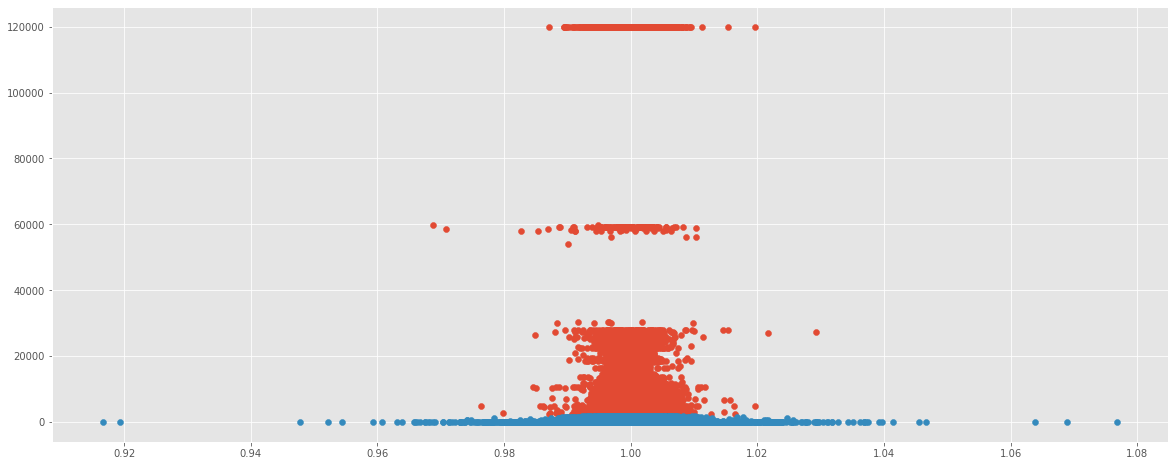

high_norm


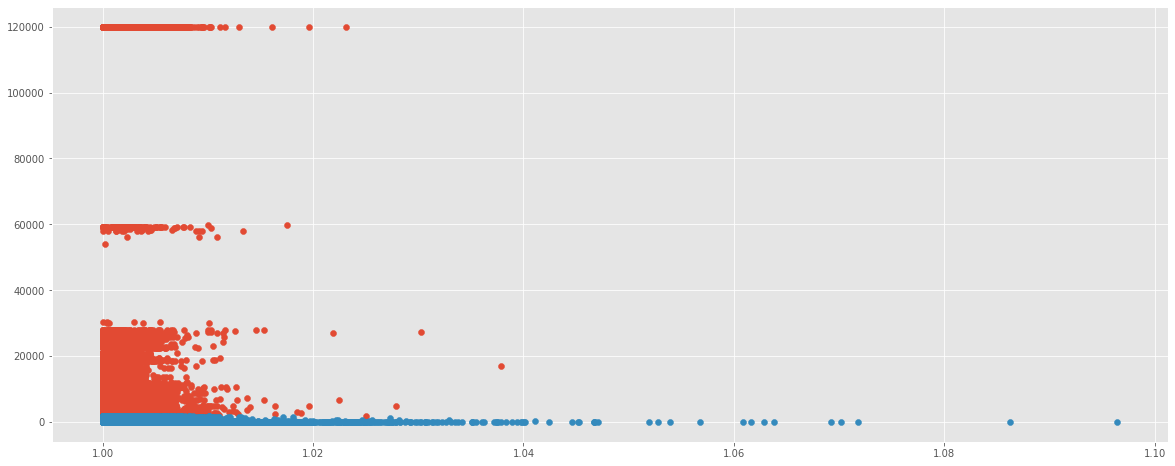

low_norm


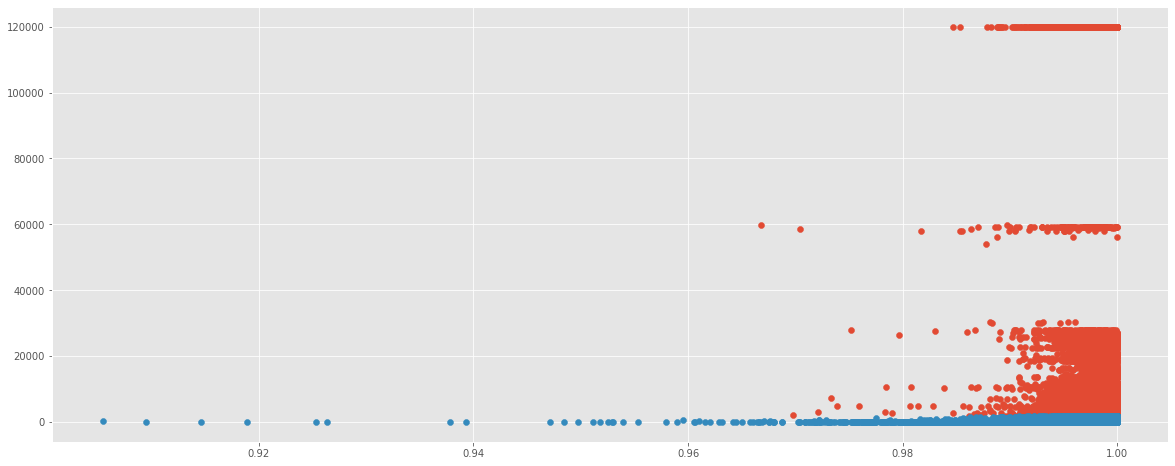

volume_pm_ma1


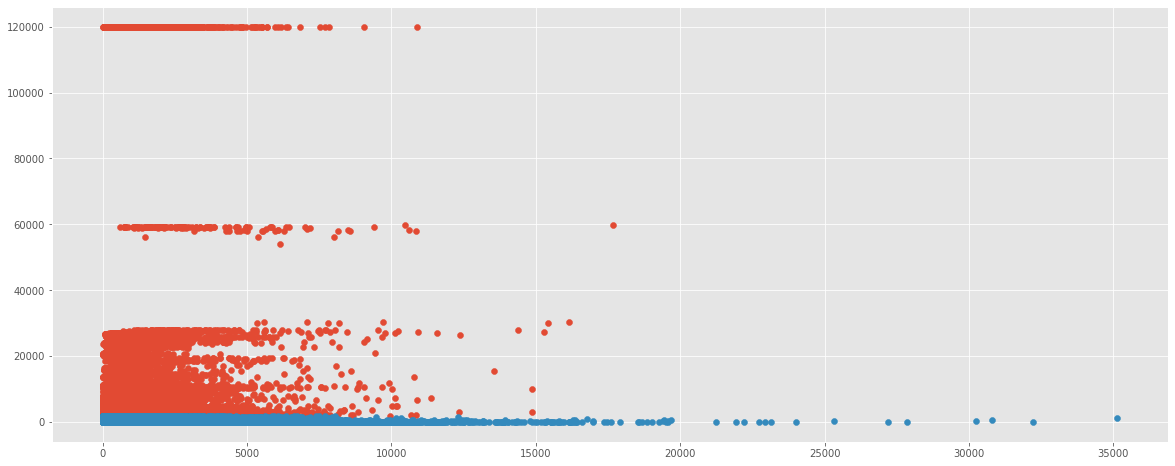

volume_pm_ma3


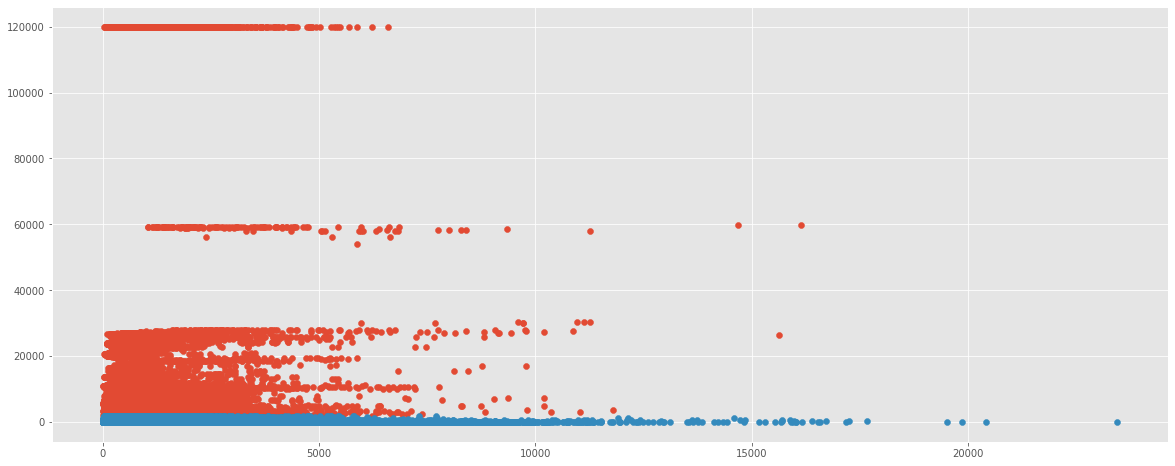

volume_pm_ma9


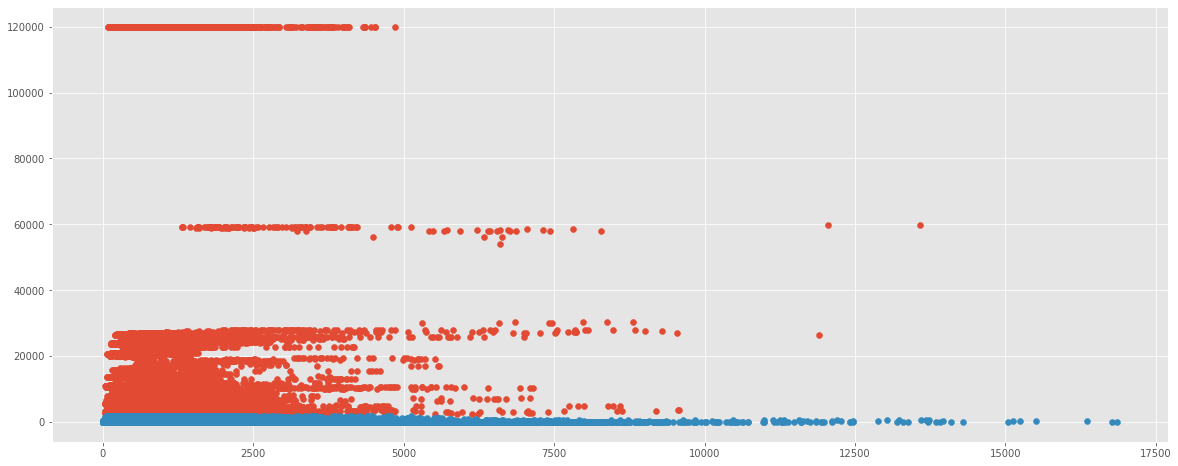

trades_pm_ma1


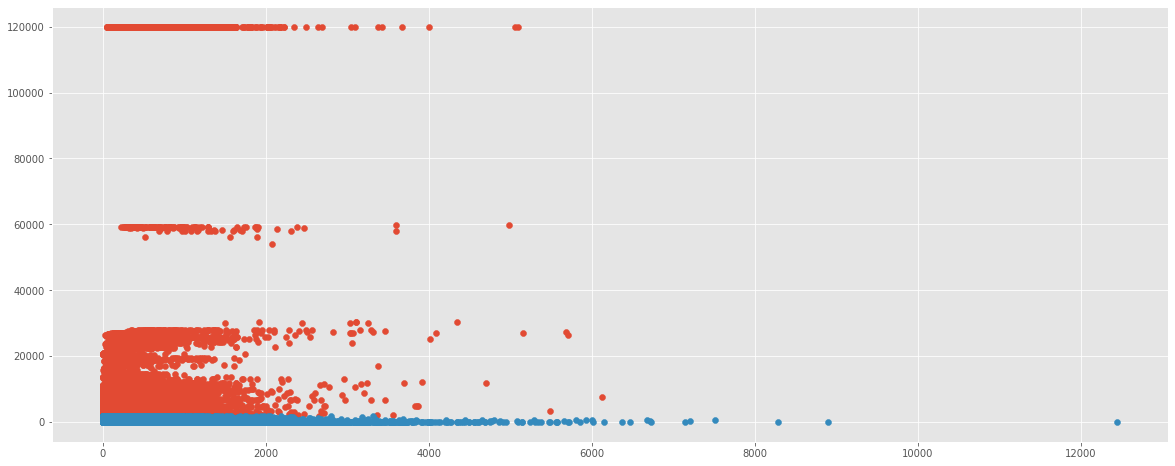

trades_pm_ma3


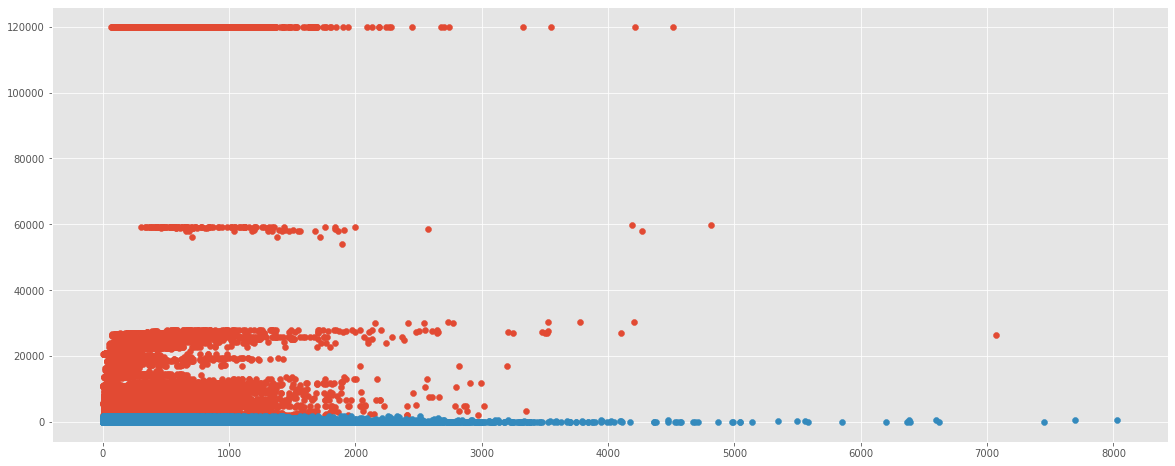

trades_pm_ma9


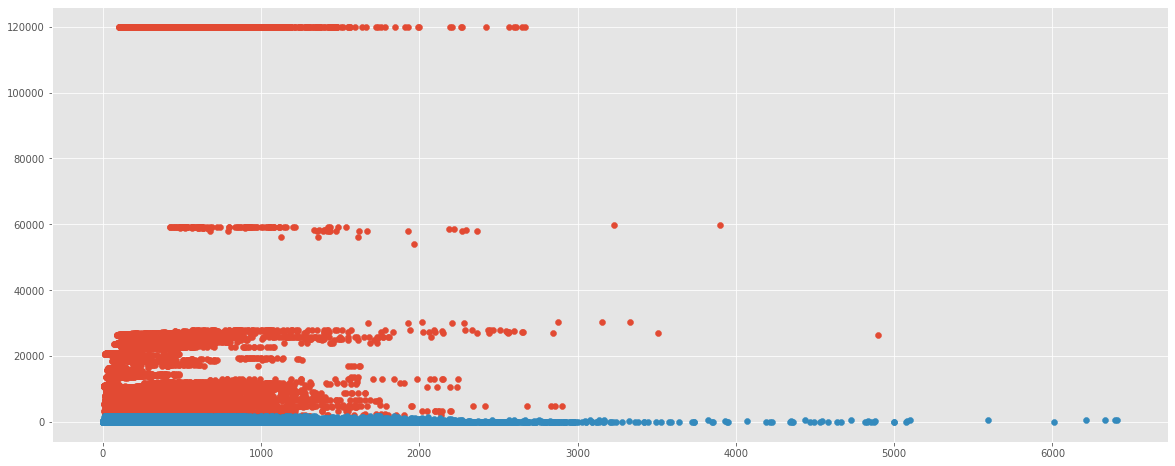

close_ma50_norm


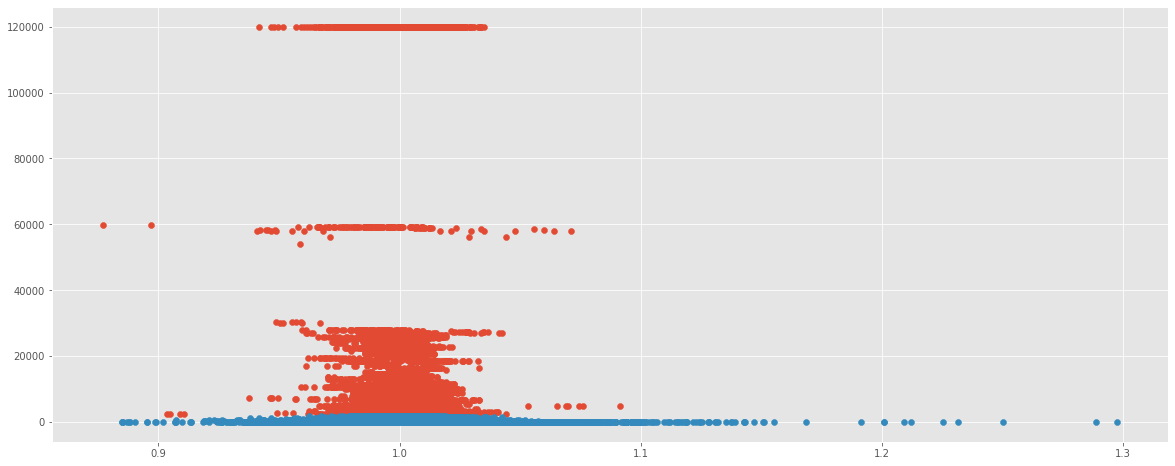

close_ma200_norm


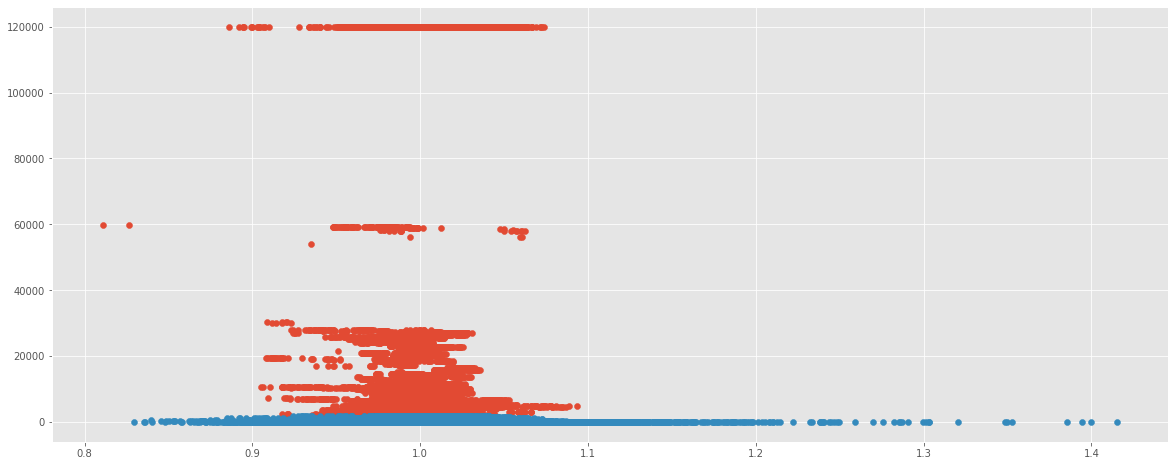

close_ema12_norm


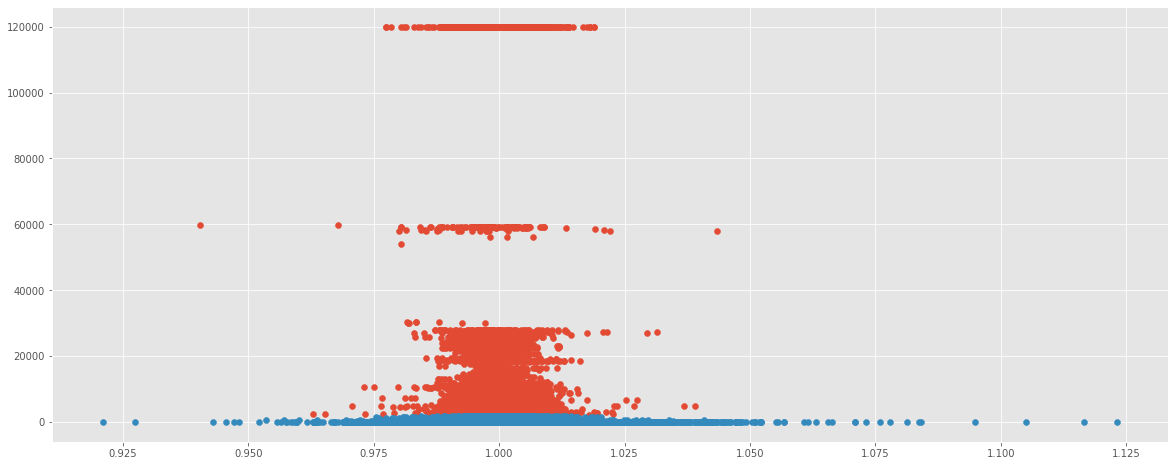

close_ema26_norm


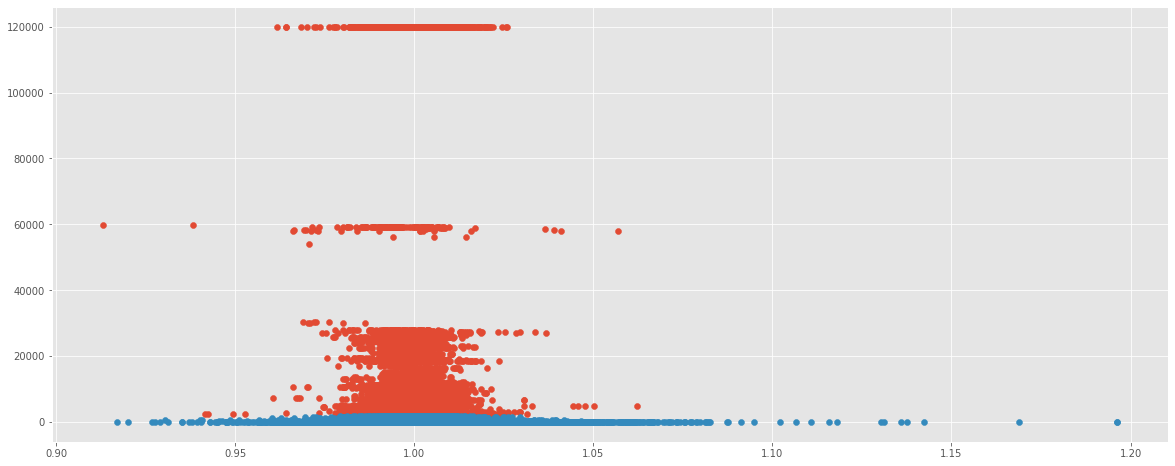

In [44]:
import matplotlib.pyplot as plt

for fc in feat_cols:
    print(fc)
    # red dots = idle signals
    plt.scatter(df_plot[~df_plot['cat'].isin(good_signals)][fc], 
                df_plot[~df_plot['cat'].isin(good_signals)]['mins2tgt'])
    # blue dots = buy signals
    plt.scatter(df_plot[df_plot['cat'].isin(good_signals)][fc], 
                df_plot[df_plot['cat'].isin(good_signals)]['mins2tgt'])
    plt.show()

In [45]:
df_plot = df_plot.join(df[['close']])

rsi14


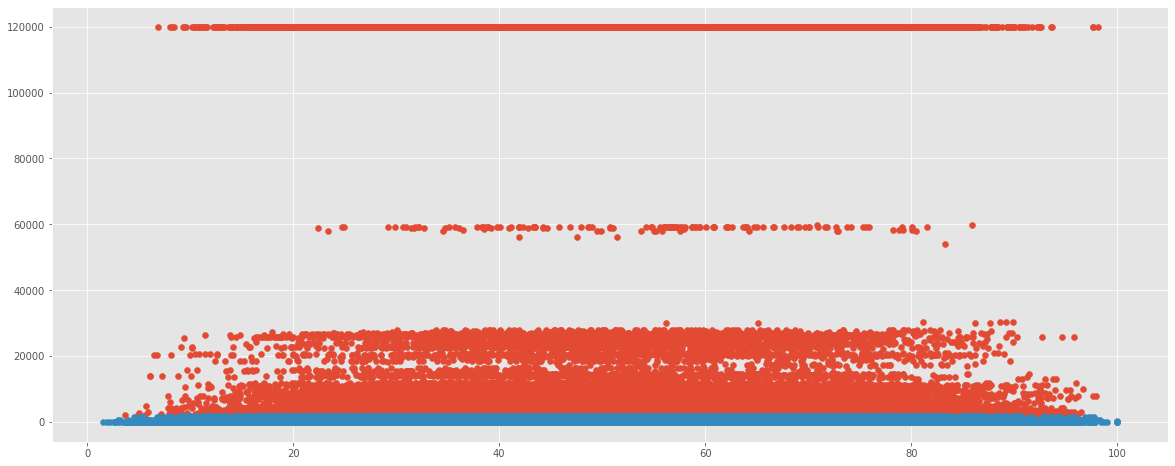

In [46]:
def rsi(data, n):
    # Make the positive gains (up) and negative gains (down) Series
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up1 = up.ewm(span=n).mean()
    roll_down1 = down.abs().ewm(span=n).mean()

    # Calculate the RSI based on EWMA
    rs1 = roll_up1 / roll_down1
    return 100.0 - (100.0 / (1.0 + rs1))

df_plot['rsi14'] = rsi(df_plot['close'], 14)

for fc in ['rsi14']:
    print(fc)
    # red dots = idle signals
    plt.scatter(df_plot[~df_plot['cat'].isin(good_signals)][fc], 
                df_plot[~df_plot['cat'].isin(good_signals)]['mins2tgt'])
    # blue dots = buy signals
    plt.scatter(df_plot[df_plot['cat'].isin(good_signals)][fc], 
                df_plot[df_plot['cat'].isin(good_signals)]['mins2tgt'])
    plt.show()

Check what happened right before the rightmost blue moments in the chart.

In [47]:
# for t0 in df_ml[df_ml['close_ema26_norm'] > 1.05].index:
#     print(f"{df.loc[t0]}\n")
#     plot(plt.plot, df[df.index <= t0].tail(26), ['close', 'high'])
# plt.show()

## Threshold study

In [48]:
# relevants = len(df_ml['cat'].isin(good_signals))

def threshold_study(field, val_min, val_max, target):
    thrs = np.arange(val_min, val_max, 0.005)
    precs = []
    for thr in thrs:
        goods = len(df_ml[(df_ml[field] >= thr) & (df_ml['cat'].isin(good_signals))])
        bads = len(df_ml[(df_ml[field] >= thr) & (~df_ml['cat'].isin(good_signals))])
        prec = goods / (goods + bads) if goods + bads > 0 else 0
#         rec = goods / relevants
        precs.append(prec if target == 'p' else goods / DAYS)
    
    plt.plot(thrs, precs, label=field)
    if target == 's':
        plt.yscale('log')

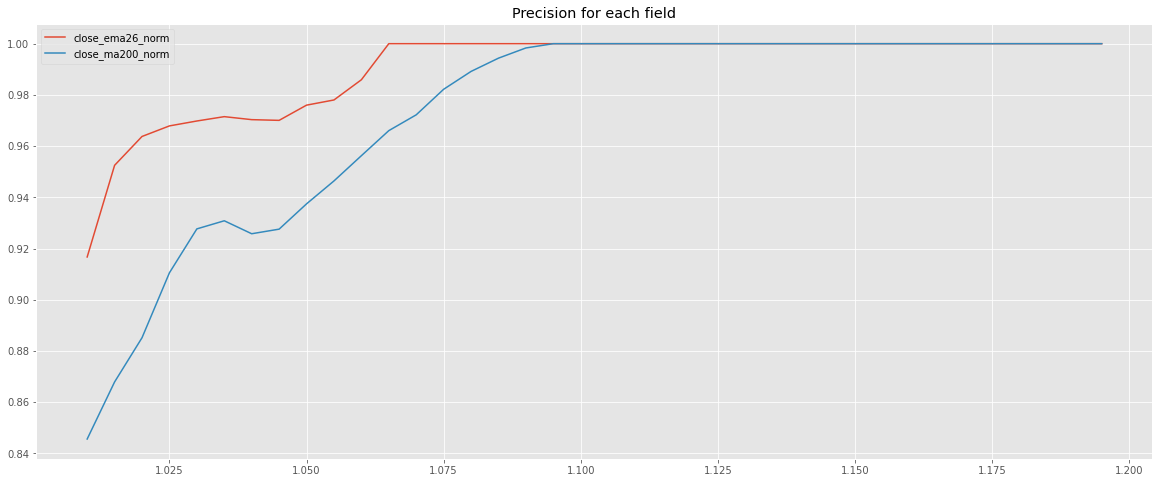

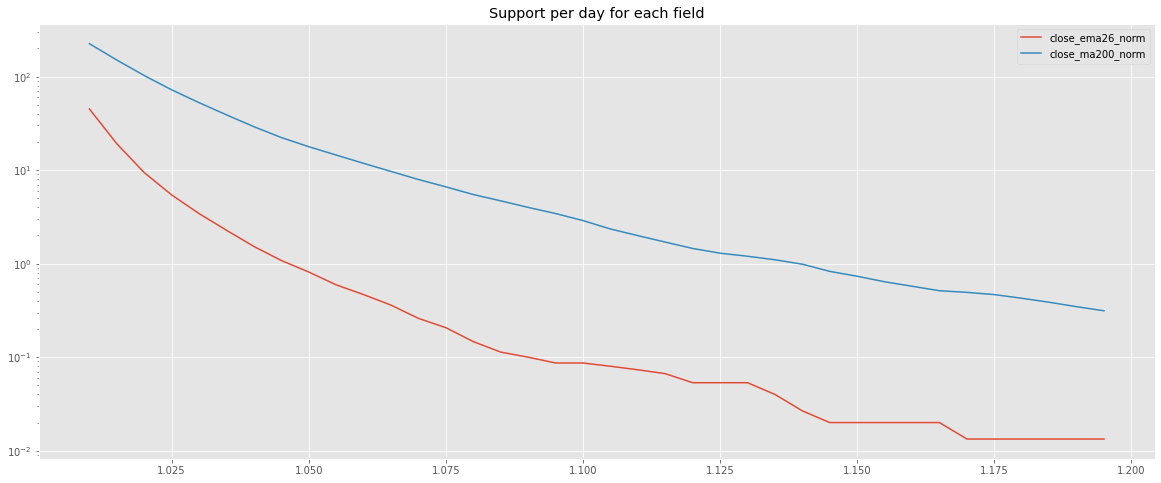

In [49]:
threshold_study('close_ema26_norm', 1.01, 1.2, 'p')
threshold_study('close_ma200_norm', 1.01, 1.2, 'p')
plt.legend(loc="best")
plt.title(f"Precision for each field")
plt.show()

threshold_study('close_ema26_norm', 1.01, 1.2, 's')
threshold_study('close_ma200_norm', 1.01, 1.2, 's')
plt.legend(loc="best")
plt.title(f"Support per day for each field")
plt.show()

## Binary model training

In [50]:
df_ml_feats_subset = df_ml_feats[['close_ema26_norm', 'close_ma200_norm']].copy()
df_ml_feats_binary = pd.DataFrame(df_ml['cat'].isin(good_signals))

In [51]:
# import numpy as np
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC

# N = 100000
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(df_ml_feats_subset.head(N), df_ml_feats_binary.head(N))

In [52]:
# x_min, x_max = 0.5, 1.5
# y_min, y_max = 0.5, 1.5
# h = .005  # step size in the mesh
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))

# # Plot the decision boundary. For that, we will assign a color to each
# # point in the mesh [x_min, x_max]x[y_min, y_max].
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(figsize=(16,10))
# plt.contourf(xx, yy, 1-Z, cmap=plt.cm.coolwarm)

# #     # Plot also the training points
# #     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
# plt.xlabel('close_ema26_norm')
# plt.ylabel('close_ma200_norm')
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# plt.title('SVC')

# plt.show()

Evaluating precision...: 100%|████████████████████████████| 213346/213346 [00:22<00:00, 9575.80it/s]


{'pre': 0.964572192513369, 'tp': 1443, 'fp': 53, 'tp/day': 9.62}
Unique days with prospect of +2%: 61
Total predicted change: +226.4%


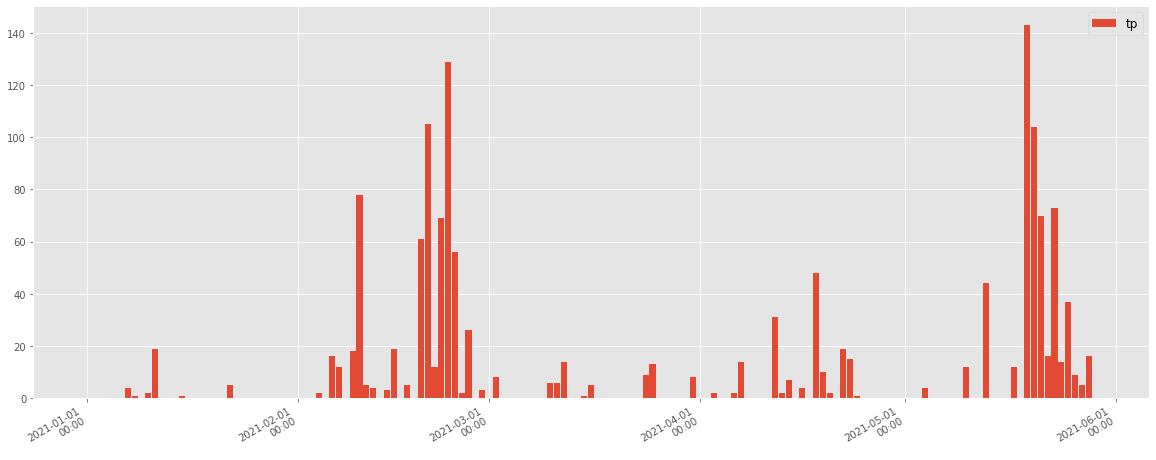

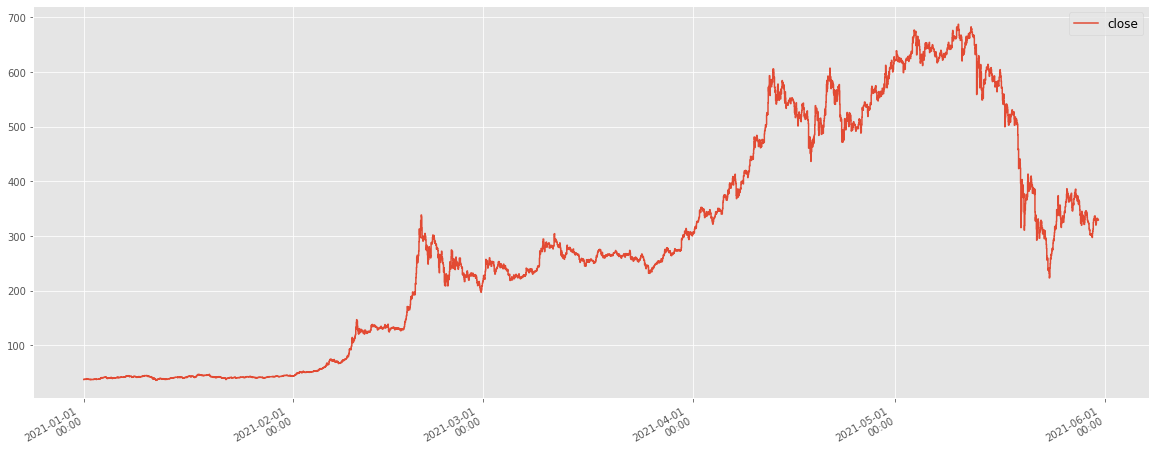

In [31]:
from collections import Counter

# manually set thresholds
thr_x, thr_y = 1.02, 1.14

tp, fp = 0, 0

true_positive = []

for (_, X), (_, y) in tqdm(zip(df_ml_feats_subset.iterrows(), df_ml_feats_binary.iterrows()), 
                           desc='Evaluating precision...', total=len(df_ml_feats_subset), ncols=100):
#     print(X['close_ema26_norm'], X['close_ma200_norm'], y['cat'])
    if X['close_ema26_norm'] >= thr_x or X['close_ma200_norm'] >= thr_y:
        if y['cat']:
            tp += 1
            true_positive.append(True)
        else:
            fp += 1
            true_positive.append(False)
    else:
        true_positive.append(False)

df_ml_feats_subset['tp'] = true_positive
df_tp = df_ml_feats_subset[df_ml_feats_subset['tp'] == True].copy()
df_tp['date'] = pd.to_datetime(df_tp.index)

evaluation = {'pre': tp/(tp+fp), 'tp': tp, 'fp': fp, 'tp/day': tp/DAYS}

print(evaluation)

c = Counter()

for i, row in df_tp.iterrows():
    c[(row['date'].year, row['date'].month, row['date'].day)] += 1

print(f"Unique days with prospect of +2%: {len(c)}")
print(f"Total predicted change: {(1.02 ** len(c) - 1) * evaluation['pre']:+.1%}")

start = pd.to_datetime(df_ml_feats_subset.index[0])
end = pd.to_datetime(df_ml_feats_subset.index[-1])

t = start
datedist = []

while True:
    datedist.append({'date': datetime(t.year, t.month, t.day), 'tp': c[(t.year, t.month, t.day)]})
    t = t + timedelta(days=1)
    if t >= end:
        break

df_datedist = pd.DataFrame.from_records(datedist, index='date')

plot(plt.bar, df_datedist, ['tp'], bar_size=.9)
plt.show()

plot(plt.plot, df[::60], ['close'])

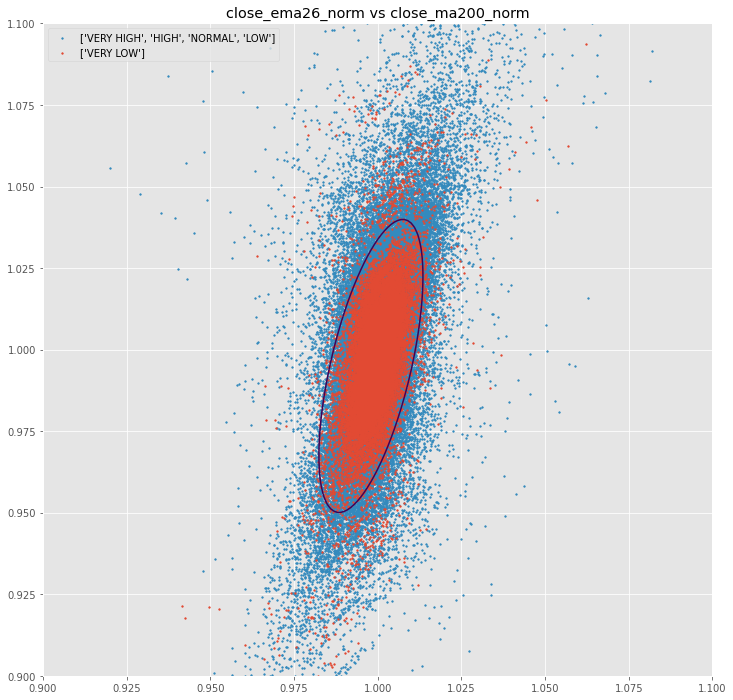

In [371]:
# def is_good_signal(X, Y, decfun=False):
#     Tx = -0.809
#     Ty = -0.234
#     F = (12*(X+Tx) - 3*(Y+Ty))**2 + (X+Tx) + (Y+Ty) - 1
#     return F if decfun else F >= 0

from math import cos, sin, pi

def is_good_signal(X, Y, decfun=False):
    A = .012
    B = .046
    x = X - .998
    y = Y - .995
    alpha = -pi/14
    F = (x * cos(alpha) + y * sin(alpha)) ** 2 / A ** 2 + (x * sin(alpha) - y * cos(alpha)) ** 2 / B ** 2 - 1
    return F if decfun else F >= 0

plt.figure(figsize=(12, 12))

bad_signals = ['VERY LOW']

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  
to_col = {1: good_signals, 0: bad_signals}

delta = 0.001
xy_min, xy_max = 0.9, 1.1
xrange = np.arange(xy_min, xy_max, delta)
yrange = np.arange(xy_min, xy_max, delta)
X, Y = np.meshgrid(xrange,yrange)

F = is_good_signal(X, Y, decfun=True)
plt.contour(X, Y, F, [0])

for c, cl in to_col.items():
    selection = df_ml['cat'].isin(cl)
    plt.scatter(df_ml_feats[selection]['close_ema26_norm'], 
                df_ml_feats[selection]['close_ma200_norm'], 
                s=3, c=palette[c], label=cl)

plt.legend(loc="upper left")
plt.title("close_ema26_norm vs close_ma200_norm")
plt.gca().set_xlim([xy_min, xy_max])
plt.gca().set_ylim([xy_min, xy_max])
plt.show()

Evaluating precision...: 100%|████████████████████████████| 213346/213346 [00:23<00:00, 8986.92it/s]


{'pre': 0.9134888227559, 'tp': 13199, 'fp': 1250, 'tp/day': 86.26797385620915}
Unique days with prospect of +2%: 112
Total predicted change: +748.0%


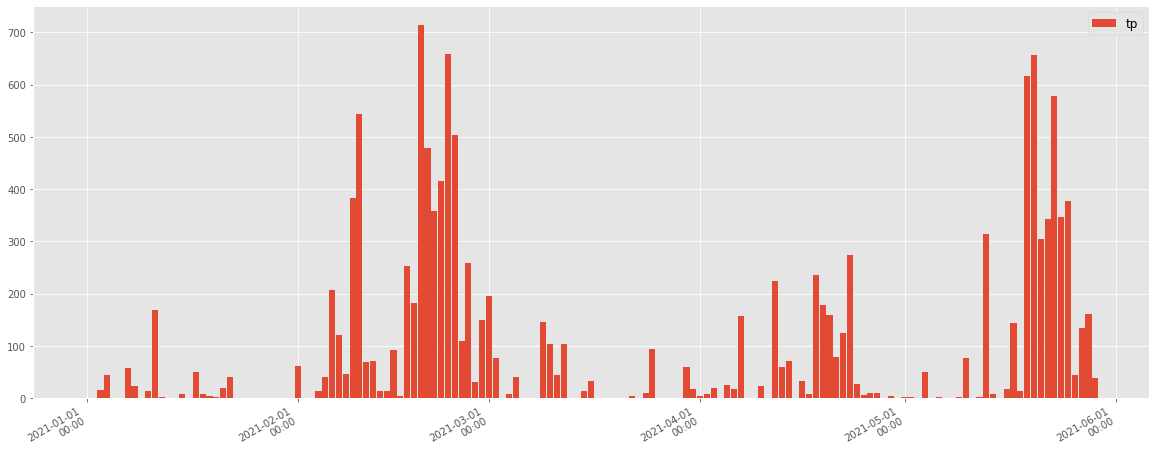

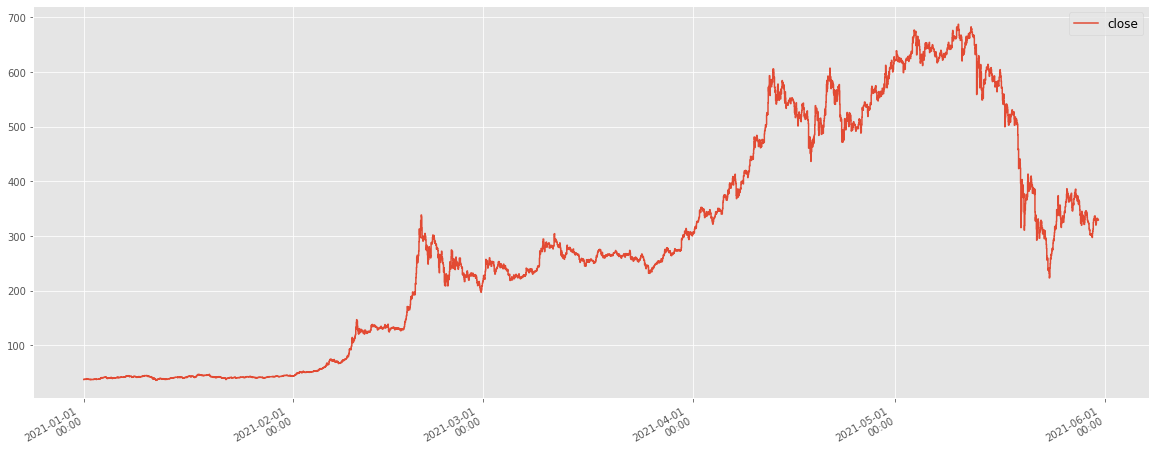

In [372]:
tp, fp = 0, 0

true_positive = []

for (_, X), (_, y) in tqdm(zip(df_ml_feats_subset.iterrows(), df_ml_feats_binary.iterrows()), 
                           desc='Evaluating precision...', total=len(df_ml_feats_subset), ncols=100):
#     print(X['close_ema26_norm'], X['close_ma200_norm'], y['cat'])
    if is_good_signal(X['close_ema26_norm'], X['close_ma200_norm']):
        if y['cat']:
            tp += 1
            true_positive.append(True)
        else:
            fp += 1
            true_positive.append(False)
    else:
        true_positive.append(False)

df_ml_feats_subset['tp'] = true_positive
df_tp = df_ml_feats_subset[df_ml_feats_subset['tp'] == True].copy()
df_tp['date'] = pd.to_datetime(df_tp.index)

evaluation = {'pre': tp/(tp+fp), 'tp': tp, 'fp': fp, 'tp/day': tp/DAYS}

print(evaluation)

c = Counter()

for i, row in df_tp.iterrows():
    c[(row['date'].year, row['date'].month, row['date'].day)] += 1

print(f"Unique days with prospect of +2%: {len(c)}")
print(f"Total predicted change: {(1.02 ** len(c) - 1) * evaluation['pre']:+.1%}")

start = pd.to_datetime(df_ml_feats_subset.index[0])
end = pd.to_datetime(df_ml_feats_subset.index[-1])

t = start
datedist = []

while True:
    datedist.append({'date': datetime(t.year, t.month, t.day), 'tp': c[(t.year, t.month, t.day)]})
    t = t + timedelta(days=1)
    if t >= end:
        break

df_datedist = pd.DataFrame.from_records(datedist, index='date')

plot(plt.bar, df_datedist, ['tp'], bar_size=.9)
plt.show()

plot(plt.plot, df[::60], ['close'])

## Simulation & stop loss optimisation

In [389]:
import pandas as pd

# def is_good_signal(X, Y, decfun=False):
#     Tx = -0.809
#     Ty = -0.234
#     F = (12*(X+Tx) - 3*(Y+Ty))**2 + (X+Tx) + (Y+Ty) - 1
#     return F if decfun else F >= 0

def is_good_signal(X, Y, decfun=False):
    A = .012
    B = .046
    x = X - .998
    y = Y - .995
    alpha = -pi/14
    F = (x * cos(alpha) + y * sin(alpha)) ** 2 / A ** 2 + (x * sin(alpha) - y * cos(alpha)) ** 2 / B ** 2 - 1
    return F if decfun else F >= 0

SYMBOL = 'BNBBUSD'
FREQ = 1
START = '20210601000000'
TARGET = 1.02
DAYS = 153
# START = '20211001000000'
# TARGET = 1.02
# DAYS = 23

df_sim = download_history_fast(SYMBOL, START, freq=FREQ, days=DAYS)

df_sim = normalise(df_sim)

df_sim['pred'] = np.vectorize(is_good_signal)(df_sim['close_ema26_norm'], df_sim['close_ma200_norm'])

df_sim = df_sim.set_index(pd.to_datetime(df_sim.index))

# ------- simulation -------

STOP = 0.94 # 0.97
HRS_FROZEN = 1 # 0

fees = 0.001
stake = [1]
stop_loss = 1 * STOP
action = []
invested = False
frozen = False

for i, row in tqdm(df_sim.iterrows(), desc='Simulating...', ncols=100, total=len(df_sim)):
    if frozen and i >= last_loss + timedelta(hours=HRS_FROZEN):
        frozen = False
    if frozen and i < last_loss + timedelta(hours=HRS_FROZEN):
        stake.append(stake[-1])
        action.append('FROZEN')
    elif row['pred'] and not invested:
        stake.append(stake[-1] * (1-fees))
        invested = True
        take_profit = row['close'] * TARGET
        stop_loss = row['close'] * STOP
        action.append('BUY')
    elif invested:
        if row['high'] > take_profit:
            invested = False
            action.append('PROFIT')
            stake.append(stake[-1] / prev_close * row['high'])
        elif row['low'] < stop_loss:
            invested = False
            action.append('LOSS')
            stake.append(stake[-1] / prev_close * row['low'])
            last_loss = i
            frozen = True
        else:
            stake.append(stake[-1] / prev_close * row['close'])
            action.append('----')
    else:
        stake.append(stake[-1])
        action.append('----')
    prev_close = row['close']

df_sim['stake'] = stake[1:]
df_sim['action'] = action

Simulating...: 100%|█████████████████████████████████████| 208503/208503 [00:16<00:00, 13006.06it/s]


In [390]:
df_sim[df_sim['action'].isin(['PROFIT', 'LOSS'])][
    ['close', 'close_ema26_norm', 'close_ma200_norm', 'stake', 'action']]

,close,close_ema26_norm,close_ma200_norm,stake,action
2021-06-02 00:23:00,360.00,0.993695,0.985022,1.019428,PROFIT
2021-06-02 16:13:00,416.13,0.988963,0.967375,1.042463,PROFIT
2021-06-03 06:10:00,417.68,0.988744,0.961618,1.063619,PROFIT
2021-06-03 23:34:00,422.99,0.995708,0.987851,1.084420,PROFIT
2021-06-04 06:25:00,386.55,1.022502,1.046357,1.014768,LOSS
...,...,...,...,...,...
2021-10-13 09:24:00,466.60,0.986299,0.960976,2.312596,PROFIT
2021-10-13 23:45:00,468.70,0.992570,0.987000,2.359085,PROFIT
2021-10-15 16:10:00,466.30,0.995061,0.990510,2.407242,PROFIT
2021-10-18 01:31:00,473.90,0.993893,0.987160,2.455065,PROFIT


<AxesSubplot:ylabel='action'>

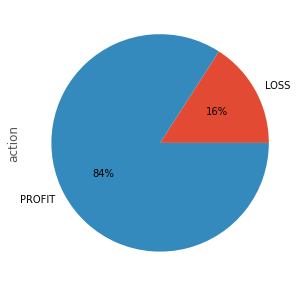

In [391]:
df_sim[df_sim['action'].isin(['PROFIT', 'LOSS'])]['action'].str.get_dummies().sum().plot(
    kind='pie', label='action', autopct='%1.0f%%', figsize=[5, 5])

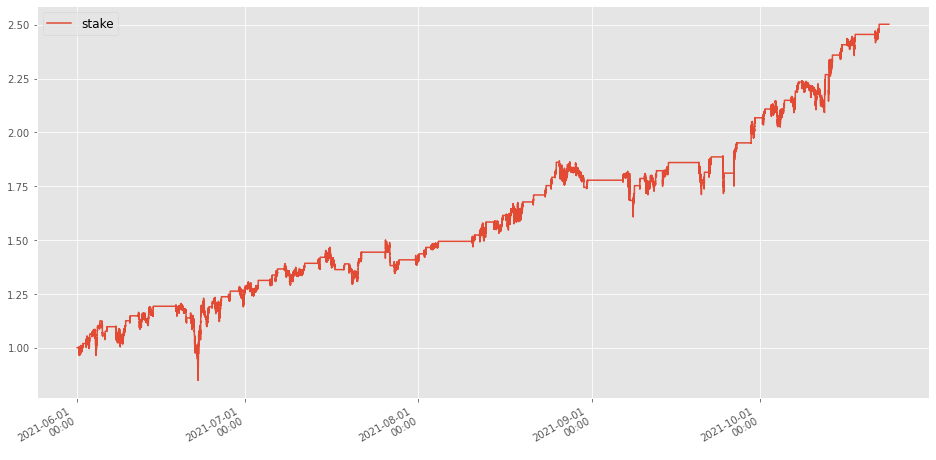

In [392]:
plot(plt.plot, df_sim, ['stake'], fig_size=(16, 8))

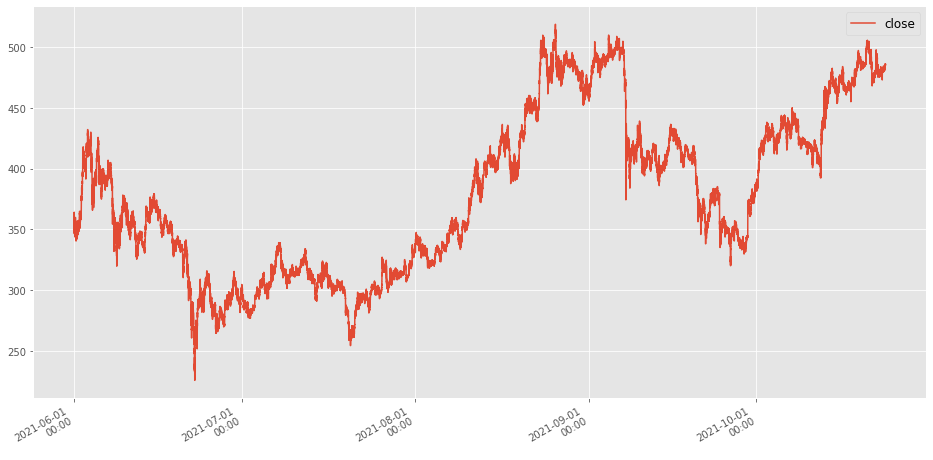

In [393]:
plot(plt.plot, df_sim, ['close'], fig_size=(16, 8))